In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

In [2]:
df1 = pd.read_csv("marketing_campaign.csv", sep='\t')

Since in the documentation, we only have explanation for the first 10 variables, we drop others

In [3]:
df2 = df1.iloc[:,:10]     

In [4]:
df2

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173
...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428


Now we identify the type of each variable.

ID is nominal.<br>
Year_Birth is ordinal.<br>
Education is nominal.<br>
Marital_Status is nominal.<br>
Income is numerical.<br>
Kidhome is numerical.<br>
Teenhome is numerical.<br>
Dt_Customer is ordinal.<br>
Recency is numerical.<br>
MintWine is numerical.<br>


In [5]:
df2.dtypes

ID                  int64
Year_Birth          int64
Education          object
Marital_Status     object
Income            float64
Kidhome             int64
Teenhome            int64
Dt_Customer        object
Recency             int64
MntWines            int64
dtype: object

#### Then, we deal with the missing values.<br>

In [6]:
pd.isnull(df2).mean()

ID                0.000000
Year_Birth        0.000000
Education         0.000000
Marital_Status    0.000000
Income            0.010714
Kidhome           0.000000
Teenhome          0.000000
Dt_Customer       0.000000
Recency           0.000000
MntWines          0.000000
dtype: float64

So, only Income contains missing values.<br>
For simplicity, we assume it to be missing completely at random. (We didn't do hypothesis test to test this since the main task of this project is clustering not missing type analysis). So, we just drop these.

In [7]:
df3 = df2[~pd.isnull(df2["Income"])]

#### Now, we do some type conversion and feature engineering

We will drop ID column, since it means nothing in clustering

We will convert Year_Birth to age and standardize it.

In [8]:
age = 2021 - df3["Year_Birth"]
std_age = (age - np.mean(age))/np.std(age)

We will do One-hot encoding on Education

In [9]:
df3["Education"].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [10]:
Graduation = (df3["Education"] == "Graduation").astype(int)
PhD = (df3["Education"] == "PhD").astype(int)
Master = (df3["Education"] == "Master").astype(int)
Cycle = (df3["Education"] == "2n Cycle").astype(int)
Basic = (df3["Education"] == "Bsic").astype(int)

We will do One-hot encoding on Marital status

In [11]:
df3["Marital_Status"].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [12]:
Married = (df3["Marital_Status"] == "Married").astype(int)
Together = (df3["Marital_Status"] == "Together").astype(int)
Single = (df3["Marital_Status"] == "Single").astype(int)
Divorced = (df3["Marital_Status"] == "Divorced").astype(int)
Widow =  (df3["Marital_Status"] == "Widow").astype(int)
Others = ((df3["Marital_Status"] == "Alone")|(df3["Marital_Status"] == "Absurd")|(df3["Marital_Status"] == "YOLO")).astype(int)

We standardize income, kids and teens

In [13]:
std_income = (df3["Income"] - np.mean(df3["Income"]))/np.std(df3["Income"])

In [14]:
std_kid = (df3["Kidhome"] - np.mean(df3["Kidhome"]))/np.std(df3["Kidhome"])

In [15]:
std_teen = (df3["Teenhome"] - np.mean(df3["Teenhome"]))/np.std(df3["Teenhome"])

For Dt_Customer, we first find the first enrolled customer and calculate the day difference between others and the first enrolled customer. We standarize it.

In [16]:
min_date = min(df3["Dt_Customer"].apply(lambda x: pd.to_datetime(x)))

In [17]:
date1 = df3["Dt_Customer"].apply(lambda x: pd.to_datetime(x))

In [18]:
day_diff = (date1 - min_date).astype(str).apply(lambda x: x.split()[0]).astype(int)

In [19]:
std_day_diff = (day_diff - np.mean(day_diff))/np.std(day_diff)

We standardize Recency

In [20]:
std_recency = (df3["Recency"] - np.mean(df3["Recency"]))/np.std(df3["Recency"])

In [21]:
std_mntwines = (df3["MntWines"] - np.mean(df3["MntWines"]))/np.std(df3["MntWines"])

Output df

In [22]:
df4 = pd.DataFrame({"Age":std_age, "Income":std_income, "MntWines":std_mntwines, "Kids":std_kid, "Teens":std_teen, "Enroll_age":std_day_diff, "Recency":std_recency, "Graduation":Graduation, "PhD":PhD, "Master":Master, "Cycle":Cycle, "Basic":Basic, "Married":Married, "Together":Together, "Single":Single, "Divorced":Divorced, "Widow":Widow, "Others":Others})

In [23]:
df5 = df4.reset_index(drop = True)

In [24]:
df5

,Age,Income,MntWines,Kids,Teens,Enroll_age,Recency,Graduation,PhD,Master,Cycle,Basic,Married,Together,Single,Divorced,Widow,Others
0,0.986443,0.234063,0.978226,-0.823039,-0.928972,-1.974875,0.310532,1,0,0,0,0,0,0,1,0,0,0
1,1.236801,-0.234559,-0.872024,1.039938,0.909066,1.665141,-0.380509,1,0,0,0,0,0,0,1,0,0,0
2,0.318822,0.769478,0.358511,-0.823039,-0.928972,0.172132,-0.795134,1,0,0,0,0,0,1,0,0,0,0
3,-1.266777,-1.017239,-0.872024,1.039938,-0.928972,1.923298,-0.795134,1,0,0,0,0,0,1,0,0,0,0
4,-1.016420,0.240221,-0.391671,1.039938,-0.928972,0.821827,1.554407,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2211,0.151917,0.356642,1.197646,-0.823039,0.909066,-0.124749,-0.104093,1,0,0,0,0,1,0,0,0,0,0
2212,1.904422,0.467539,0.299208,2.902916,0.909066,1.940508,0.241428,0,1,0,0,0,0,1,0,0,0,0
2213,-1.016420,0.188091,1.787710,-0.823039,-0.928972,0.847643,1.450751,1,0,0,0,0,0,0,0,1,0,0
2214,1.069896,0.675388,0.364441,-0.823039,0.909066,0.843341,-1.417072,0,0,1,0,0,0,1,0,0,0,0


In [25]:
df5.to_csv("cleaned_data.csv")

In [26]:
# drop categorical columns
df6 = df5.drop(['Graduation','PhD','Master','Cycle','Basic','Married','Together','Single','Divorced','Widow','Others'], axis=1)

In [27]:
#create new columns by using formula
df6['MntWines/Income'] = df3['MntWines'] / df3['Income']
std_MntWines_Income = (df6['MntWines/Income'] - np.mean(df6['MntWines/Income']))/np.std(df6['MntWines/Income'])
df6['MntWines/Income'] = std_MntWines_Income

In [28]:
#drop Income and MntWines columns (for kmeans)
df7 = df6.drop(["Income","MntWines"],axis=1)

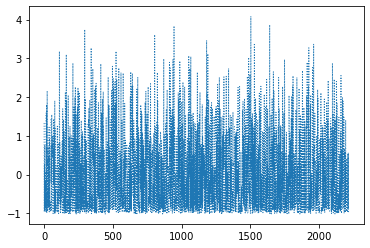

In [29]:
#plot the Mntwines/Income
plt.plot(np.arange(2216),df7['MntWines/Income'],ls = 'dotted',lw=1)

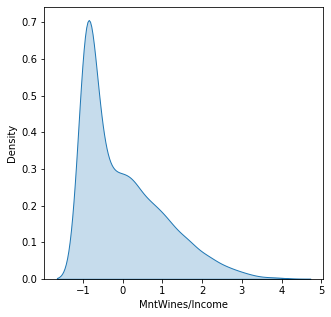

In [30]:
#density graph of the Mines/Income
plt.figure(figsize = (5,5))
sb.kdeplot(df7['MntWines/Income'] , fill = True)
plt.show()

In [31]:
# drop the formula colmn
df8 = df7.drop(['MntWines/Income'],axis=1)

In [32]:
# take a look of the dataset that will be used to run kmeans
df8

,Age,Kids,Teens,Enroll_age,Recency
0,0.986443,-0.823039,-0.928972,-1.974875,0.310532
1,1.236801,1.039938,0.909066,1.665141,-0.380509
2,0.318822,-0.823039,-0.928972,0.172132,-0.795134
3,-1.266777,1.039938,-0.928972,1.923298,-0.795134
4,-1.016420,1.039938,-0.928972,0.821827,1.554407
...,...,...,...,...,...
2211,0.151917,-0.823039,0.909066,-0.124749,-0.104093
2212,1.904422,2.902916,0.909066,1.940508,0.241428
2213,-1.016420,-0.823039,-0.928972,0.847643,1.450751
2214,1.069896,-0.823039,0.909066,0.843341,-1.417072


In [33]:
#run the kmeans
kmeans1 = KMeans(n_clusters=5, random_state=0).fit(df8)

In [34]:
#corresponding labels
array = kmeans1.labels_

In [35]:
#assign the lables to datapoints
df8["cluster1"] = array

In [36]:
#add back the formula column
df9 = df8
df9["MntWines/Income"] = std_MntWines_Income

In [37]:
#display the mean of each feature after clustring
df9.groupby("cluster1").mean()

,Age,Kids,Teens,Enroll_age,Recency,MntWines/Income
cluster1,,,,,,
0,-1.013280,-0.823039,-0.928972,-0.078256,-0.103551,-0.006500
1,0.296117,1.168880,1.001187,0.086490,0.014077,0.001678
2,1.100530,-0.817144,-0.923156,0.067657,0.099283,0.004008
3,0.405489,-0.823039,0.994029,-0.071646,-0.006825,-0.030497
4,-0.802664,1.101674,-0.928972,0.026984,0.000372,0.038622


In [38]:
# calculate formula2 (wine/all products)
formula2 = df1['MntWines'] / (df1['MntWines'] + df1['MntFruits'] + df1['MntMeatProducts'] + df1['MntFishProducts'] + df1['MntSweetProducts']
                             + df1['MntGoldProds'])
df8['MntWine/All_Products'] = formula2

In [39]:
#standardize formula2
std_MntWines_AllProducts = (df8['MntWine/All_Products'] - np.mean(df8['MntWine/All_Products']))/np.std(df8['MntWine/All_Products'])
#add the new formula to the dataframe
df8['MntWine/All_Products'] = std_MntWines_AllProducts

In [40]:
#take a look of dataset
df8

,Age,Kids,Teens,Enroll_age,Recency,cluster1,MntWines/Income,MntWine/All_Products
0,0.986443,-0.823039,-0.928972,-1.974875,0.310532,2,1.327251,-0.289712
1,1.236801,1.039938,0.909066,1.665141,-0.380509,1,-0.965033,-0.225226
2,0.318822,-0.823039,-0.928972,0.172132,-0.795134,2,0.260233,0.395571
3,-1.266777,1.039938,-0.928972,1.923298,-0.795134,4,-0.927390,-1.101683
4,-1.016420,1.039938,-0.928972,0.821827,1.554407,4,-0.379266,-0.214065
...,...,...,...,...,...,...,...,...
2211,0.151917,-0.823039,0.909066,-0.124749,-0.104093,3,0.244655,-0.609511
2212,1.904422,2.902916,0.909066,1.940508,0.241428,1,-0.886288,0.229550
2213,-1.016420,-0.823039,-0.928972,0.847643,1.450751,0,0.564772,-0.196591
2214,1.069896,-0.823039,0.909066,0.843341,-1.417072,3,-0.530673,-0.367344


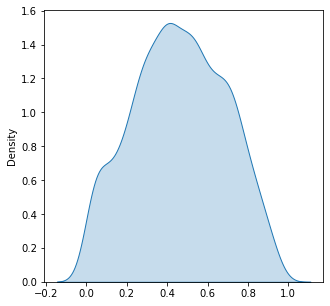

In [41]:
#density graph of the Mines/All_products
plt.figure(figsize = (5,5))
sb.kdeplot(formula2 , fill = True)
plt.show()

In [42]:
#show the result of the second forumula
df9.groupby("cluster1").mean()

,Age,Kids,Teens,Enroll_age,Recency,MntWines/Income,MntWine/All_Products
cluster1,,,,,,,
0,-1.013280,-0.823039,-0.928972,-0.078256,-0.103551,-0.006500,-0.020619
1,0.296117,1.168880,1.001187,0.086490,0.014077,0.001678,0.038694
2,1.100530,-0.817144,-0.923156,0.067657,0.099283,0.004008,-0.000443
3,0.405489,-0.823039,0.994029,-0.071646,-0.006825,-0.030497,-0.042827
4,-0.802664,1.101674,-0.928972,0.026984,0.000372,0.038622,0.035671


In [43]:
#create new dataframe that contains 7 features
df10 = pd.DataFrame({"Age":std_age, "Income":std_income, "MntWines":std_mntwines, "Kids":std_kid, "Teens":std_teen, "Enroll_age":std_day_diff, "Recency":std_recency})

In [44]:
#features of the data and normalize them
features = (['Age','Income','Teens','Enroll_age','Recency','MntWines','Kids'])
x = df10.loc[:, features].values
x = StandardScaler().fit_transform(x) # normalizing the features

In [45]:
## run PCA on the data (2D)
pca = PCA(n_components=2)
pca.fit(df10)

PCA(n_components=2)

In [46]:
#transform the dataset
df11 = pca.fit_transform(x)

principal_df = pd.DataFrame(data = df11
             , columns = ['principal component 1', 'principal component 2',])

In [47]:
#dataset after the PCA
principal_df

,principal component 1,principal component 2
0,1.470564,0.679458
1,-0.824894,-1.963115
2,1.006921,0.766429
3,-2.263090,0.727441
4,-1.123695,0.958345
...,...,...
2211,1.471325,-0.325621
2212,-0.583524,-2.211227
2213,1.057053,1.589641
2214,1.354488,-1.100767


In [48]:
#print out the varaince ratio
pca.explained_variance_ratio_

array([0.30335721, 0.18368963])

<Figure size 432x288 with 0 Axes>

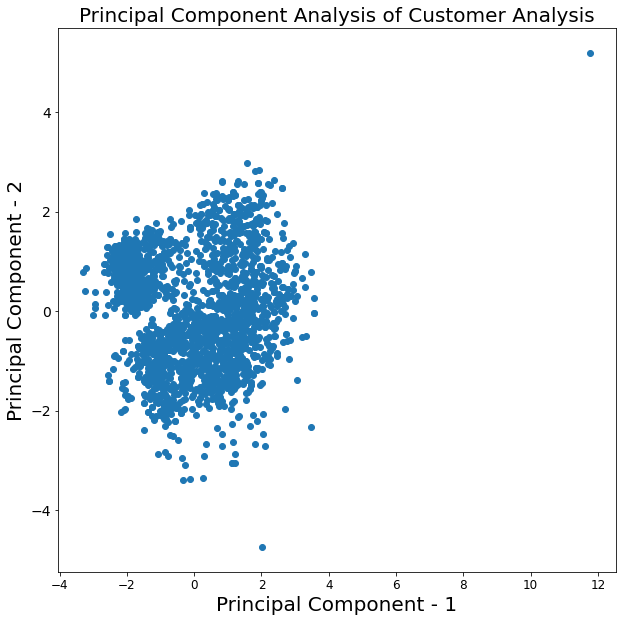

In [49]:
#visualize the 2D data
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Customer Analysis",fontsize=20)
plt.scatter(principal_df['principal component 1'],principal_df['principal component 2'])


In [50]:
# run PCA to get all components
pca2 = PCA(n_components=7)
pca2.fit(df10)

PCA(n_components=7)

In [51]:
##print out the varaiance ratio
pca2.explained_variance_ratio_

array([0.30335721, 0.18368963, 0.14854715, 0.1386951 , 0.09117064,
       0.0789861 , 0.05555415])

In [52]:
#transform the data
df12 = pca2.fit_transform(x)

In [53]:
df12.shape

(2216, 7)

In [54]:
#convert to dataframe
df13 = pd.DataFrame(StandardScaler().fit_transform(df12), 
                    columns=['principal component1','principal component2','principal component3','principal component4','principal component5','principal component6','principal component7'], index=df6.index)

#drop the last three column
df14 = df13.drop(df13.columns[[4,5,6]], axis=1)

In [55]:
# take a look of the dataset after PCA
df14

,principal component1,principal component2,principal component3,principal component4
0,1.009155,0.599199,-1.484474,0.861259
1,-0.566072,-1.731228,1.329067,-0.586936
2,0.690986,0.675897,0.867258,0.266582
3,-1.553015,0.641515,1.804550,-0.611720
4,-0.771120,0.845144,-0.319718,-1.893810
...,...,...,...,...
2211,1.009677,-0.287158,-0.082824,0.255029
2212,-0.400435,-1.950033,1.081970,-1.303376
2213,0.725388,1.401870,-0.265498,-1.797742
2214,0.929499,-0.970743,1.559623,0.607947


In [56]:
# run kmeans on df14
kmeans2 = KMeans(n_clusters=3, random_state=3).fit(df14)

In [57]:
#labels
array2 = kmeans2.labels_

#add lables to the dataset
df14["cluster2"] = array2

In [58]:
#add two formula
df14["MntWines/Income"] = std_MntWines_Income
df14['MntWine/All_Products'] = std_MntWines_AllProducts

In [59]:
df14

,principal component1,principal component2,principal component3,principal component4,cluster2,MntWines/Income,MntWine/All_Products
0,1.009155,0.599199,-1.484474,0.861259,0,1.327251,-0.289712
1,-0.566072,-1.731228,1.329067,-0.586936,1,-0.965033,-0.225226
2,0.690986,0.675897,0.867258,0.266582,0,0.260233,0.395571
3,-1.553015,0.641515,1.804550,-0.611720,2,-0.927390,-1.101683
4,-0.771120,0.845144,-0.319718,-1.893810,2,-0.379266,-0.214065
...,...,...,...,...,...,...,...
2211,1.009677,-0.287158,-0.082824,0.255029,0,0.244655,-0.609511
2212,-0.400435,-1.950033,1.081970,-1.303376,1,-0.886288,0.229550
2213,0.725388,1.401870,-0.265498,-1.797742,0,0.564772,-0.196591
2214,0.929499,-0.970743,1.559623,0.607947,1,-0.530673,-0.367344


In [60]:
#view the result of kmeans after PCA
df14.groupby("cluster2").mean()

,principal component1,principal component2,principal component3,principal component4,MntWines/Income,MntWine/All_Products
cluster2,,,,,,
0,1.002905,0.725564,0.078424,-0.203502,-0.037571,-0.033949
1,0.036576,-0.924945,-0.029423,0.148862,0.009818,0.000581
2,-1.139698,0.670763,-0.038383,-0.014366,0.025296,0.035721


In [61]:
#view the reuslt without PCA
df9.groupby("cluster1").mean()

,Age,Kids,Teens,Enroll_age,Recency,MntWines/Income,MntWine/All_Products
cluster1,,,,,,,
0,-1.013280,-0.823039,-0.928972,-0.078256,-0.103551,-0.006500,-0.020619
1,0.296117,1.168880,1.001187,0.086490,0.014077,0.001678,0.038694
2,1.100530,-0.817144,-0.923156,0.067657,0.099283,0.004008,-0.000443
3,0.405489,-0.823039,0.994029,-0.071646,-0.006825,-0.030497,-0.042827
4,-0.802664,1.101674,-0.928972,0.026984,0.000372,0.038622,0.035671


In [62]:
df10

,Age,Income,MntWines,Kids,Teens,Enroll_age,Recency
0,0.986443,0.234063,0.978226,-0.823039,-0.928972,-1.974875,0.310532
1,1.236801,-0.234559,-0.872024,1.039938,0.909066,1.665141,-0.380509
2,0.318822,0.769478,0.358511,-0.823039,-0.928972,0.172132,-0.795134
3,-1.266777,-1.017239,-0.872024,1.039938,-0.928972,1.923298,-0.795134
4,-1.016420,0.240221,-0.391671,1.039938,-0.928972,0.821827,1.554407
...,...,...,...,...,...,...,...
2235,0.151917,0.356642,1.197646,-0.823039,0.909066,-0.124749,-0.104093
2236,1.904422,0.467539,0.299208,2.902916,0.909066,1.940508,0.241428
2237,-1.016420,0.188091,1.787710,-0.823039,-0.928972,0.847643,1.450751
2238,1.069896,0.675388,0.364441,-0.823039,0.909066,0.843341,-1.417072


In [63]:
# drop two formula column
df15 = df14.drop(['MntWines/Income','MntWine/All_Products'],axis=1)

In [64]:
df15

,principal component1,principal component2,principal component3,principal component4,cluster2
0,1.009155,0.599199,-1.484474,0.861259,0
1,-0.566072,-1.731228,1.329067,-0.586936,1
2,0.690986,0.675897,0.867258,0.266582,0
3,-1.553015,0.641515,1.804550,-0.611720,2
4,-0.771120,0.845144,-0.319718,-1.893810,2
...,...,...,...,...,...
2211,1.009677,-0.287158,-0.082824,0.255029,0
2212,-0.400435,-1.950033,1.081970,-1.303376,1
2213,0.725388,1.401870,-0.265498,-1.797742,0
2214,0.929499,-0.970743,1.559623,0.607947,1


<Figure size 432x288 with 0 Axes>

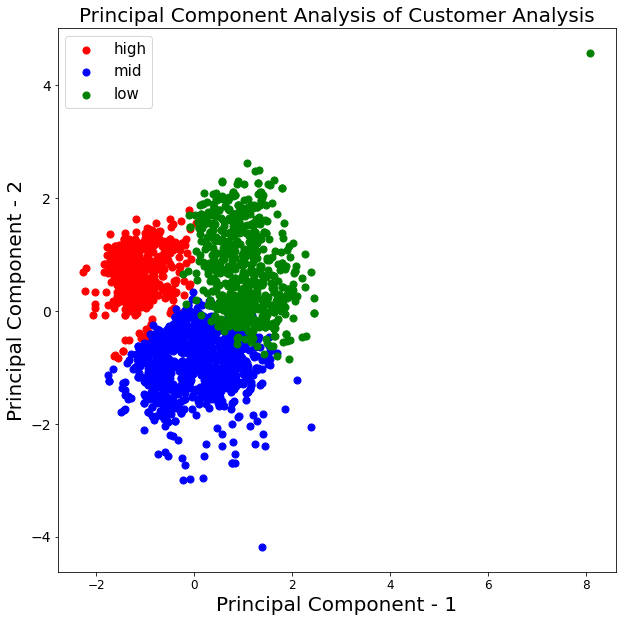

In [65]:
#plot the result of clustering
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Customer Analysis",fontsize=20)
targets = [2,1,0]
colors = ['r', 'b','g']
for target, color in zip(targets,colors):
    indicesToKeep = df15['cluster2'] == target
    plt.scatter(df15.loc[indicesToKeep, 'principal component1']
               , df15.loc[indicesToKeep, 'principal component2'], c = color, s = 50)

plt.legend(['high','mid','low'],prop={'size': 15})

In [66]:
df9

,Age,Kids,Teens,Enroll_age,Recency,cluster1,MntWines/Income,MntWine/All_Products
0,0.986443,-0.823039,-0.928972,-1.974875,0.310532,2,1.327251,-0.289712
1,1.236801,1.039938,0.909066,1.665141,-0.380509,1,-0.965033,-0.225226
2,0.318822,-0.823039,-0.928972,0.172132,-0.795134,2,0.260233,0.395571
3,-1.266777,1.039938,-0.928972,1.923298,-0.795134,4,-0.927390,-1.101683
4,-1.016420,1.039938,-0.928972,0.821827,1.554407,4,-0.379266,-0.214065
...,...,...,...,...,...,...,...,...
2211,0.151917,-0.823039,0.909066,-0.124749,-0.104093,3,0.244655,-0.609511
2212,1.904422,2.902916,0.909066,1.940508,0.241428,1,-0.886288,0.229550
2213,-1.016420,-0.823039,-0.928972,0.847643,1.450751,0,0.564772,-0.196591
2214,1.069896,-0.823039,0.909066,0.843341,-1.417072,3,-0.530673,-0.367344


In [67]:
df16 = df7.drop(['MntWines/Income'],axis=1)

In [68]:
df16

,Age,Kids,Teens,Enroll_age,Recency
0,0.986443,-0.823039,-0.928972,-1.974875,0.310532
1,1.236801,1.039938,0.909066,1.665141,-0.380509
2,0.318822,-0.823039,-0.928972,0.172132,-0.795134
3,-1.266777,1.039938,-0.928972,1.923298,-0.795134
4,-1.016420,1.039938,-0.928972,0.821827,1.554407
...,...,...,...,...,...
2211,0.151917,-0.823039,0.909066,-0.124749,-0.104093
2212,1.904422,2.902916,0.909066,1.940508,0.241428
2213,-1.016420,-0.823039,-0.928972,0.847643,1.450751
2214,1.069896,-0.823039,0.909066,0.843341,-1.417072


In [69]:
df17 = df15.drop(['cluster2'],axis=1)

In [70]:
#data after doing pca
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df17)
  labels = kmeans.labels_
  sil.append(silhouette_score(x, labels, metric = 'euclidean'))

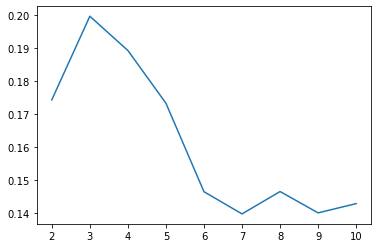

In [71]:
plt.plot(range(2,11),sil)

In [72]:
df17

,principal component1,principal component2,principal component3,principal component4
0,1.009155,0.599199,-1.484474,0.861259
1,-0.566072,-1.731228,1.329067,-0.586936
2,0.690986,0.675897,0.867258,0.266582
3,-1.553015,0.641515,1.804550,-0.611720
4,-0.771120,0.845144,-0.319718,-1.893810
...,...,...,...,...
2211,1.009677,-0.287158,-0.082824,0.255029
2212,-0.400435,-1.950033,1.081970,-1.303376
2213,0.725388,1.401870,-0.265498,-1.797742
2214,0.929499,-0.970743,1.559623,0.607947


In [73]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = df17
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

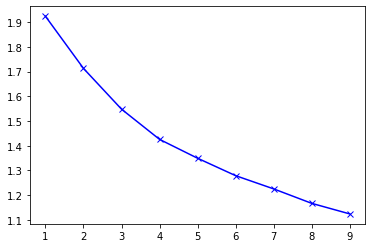

In [74]:
plt.plot(K,distortions,'bx-')